# Algorithm Implementation: Single Perceptron

## Overview
Implementation of a Single Perceptron classifier to categorize countries based on development indicators. This fundamental neural network model helps us understand the linear separability of development features and demonstrates basic principles of neural network learning.

## Objectives
- Implement a basic neural network classifier for development status
- Analyze linear separability of development indicators
- Study convergence properties with real-world data
- Compare performance with logistic regression baseline

## Key Questions
1. Are development indicators linearly separable for classification?
2. How does the perceptron perform compared to other linear classifiers?
3. What insights can we gain about feature importance from learned weights?
4. How do learning rate and number of iterations affect model performance?

In [2]:
# Import required libraries
import wbdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import Perceptron
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualizations
#plt.style.use('seaborn')
sns.set_palette('husl')
%matplotlib inline

## Data Collection and Preprocessing

### 1. Data Collection
We'll fetch data from the World Bank's World Development Indicators database using the `wbdata` package.

In [ ]:
# Define indicators
indicators = {
    "NY.GDP.PCAP.CD": "GDP per capita",
    "SP.DYN.LE00.IN": "Life Expectancy",
    "EN.GHG.ALL.MT.CE.AR5": "Total GHG Emissions",
    "SP.POP.TOTL": "Population",
    "SL.TLF.CACT.ZS": "Labor Force Participation",
    "MS.MIL.XPND.GD.ZS": "Military Expenditure"
}

def fetch_data():
    print("Fetching data from World Bank...")
    data = {}
    
    # Fetch indicators data
    for indicator in indicators.keys():
        print(f"Fetching {indicators[indicator]}...")
        result = wbdata.get_data(indicator)
        data[indicators[indicator]] = result
    
    # Fetch country metadata (removing the 'display' argument)
    print("Fetching country metadata...")
    countries = wbdata.get_countries()
    
    # Check structure and extract income groups
    income_groups = {
        c['id']: c['incomeLevel']['value']
        for c in countries if 'incomeLevel' in c
    }
    
    # Convert to DataFrame
    print("\nProcessing data...")
    rows = []
    for indicator_name, indicator_data in data.items():
        for entry in indicator_data:
            if entry['value'] is not None:
                rows.append({
                    'country': entry['country']['value'],
                    'country_id': entry['country']['id'],
                    'year': entry['date'],
                    'indicator': indicator_name,
                    'value': float(entry['value'])
                })
    
    df = pd.DataFrame(rows)
    
    # Pivot and process
    df = df.pivot_table(
        index=['country', 'country_id', 'year'],
        columns='indicator',
        values='value'
    ).reset_index()
    
    # Add income groups
    df['Income Group'] = df['country_id'].map(income_groups)
    
    # Sort and compute derived metrics
    df['year'] = pd.to_numeric(df['year'])
    df = df.sort_values('year', ascending=False)
    df["GHG Emissions per Capita"] = (df["Total GHG Emissions"] * 1_000_000) / df["Population"]
    df = df.drop(columns=["Total GHG Emissions", "Population"])
    
    return df.head()

# Fetch the data
df = fetch_data()


Fetching data from World Bank...
Fetching GDP per capita...
Fetching Life Expectancy...
Fetching Total GHG Emissions...
Fetching Population...
Fetching Labor Force Participation...
Fetching Military Expenditure...
Fetching country metadata...



Processing data...


In [17]:
df.head()

indicator,country,country_id,year,GDP per capita,Labor Force Participation,Life Expectancy,Military Expenditure,Income Group,GHG Emissions per Capita
16838,"Yemen, Rep.",YE,2023,477.409029,32.960000,NaN,NaN,NaN,NaN
8765,Least developed countries: UN classification,XL,2023,1306.234785,63.647177,NaN,1.427610,NaN,NaN
16902,Zambia,ZM,2023,1330.727806,59.419000,NaN,1.303002,NaN,NaN
8573,Latin America & Caribbean (excluding high income),XJ,2023,10180.705525,63.318159,NaN,1.001839,NaN,NaN
15268,Tanzania,TZ,2023,1224.489624,83.740000,NaN,1.151694,NaN,NaN


### 2. Data Preprocessing
We'll clean the data, handle missing values, and prepare it for perceptron analysis.

In [10]:
def preprocess_data(df):
    # Take most recent year's data for each country
    df_recent = df.sort_values('year', ascending=False).groupby('country').first().reset_index()
    
    # Log transform GDP and GHG emissions
    df_recent['GDP per capita (log)'] = np.log(df_recent['GDP per capita'])
    df_recent['GHG Emissions per Capita (log)'] = np.log(df_recent['GHG Emissions per Capita'])
    
    # Handle missing values
    numeric_columns = df_recent.select_dtypes(include=[np.number]).columns
    df_recent[numeric_columns] = df_recent[numeric_columns].fillna(df_recent[numeric_columns].mean())
    
    # Create binary development status (High Income vs Others)
    df_recent['Development Status'] = df_recent['Income Group'].apply(
        lambda x: 1 if x == 'High income' else 0
    )
    
    # Remove outliers using IQR method
    Q1 = df_recent['GDP per capita'].quantile(0.25)
    Q3 = df_recent['GDP per capita'].quantile(0.75)
    IQR = Q3 - Q1
    df_clean = df_recent[
        (df_recent['GDP per capita'] >= Q1 - 1.5 * IQR) &
        (df_recent['GDP per capita'] <= Q3 + 1.5 * IQR)
    ]
    
    return df_clean

# Preprocess the data
df_processed = preprocess_data(df)

# Display basic information about the processed dataset
print("\nProcessed Dataset Info:")
print(df_processed.info())

print("\nSample of processed data:")
print(df_processed.head())

print("\nClass distribution:")
print(df_processed['Development Status'].value_counts(normalize=True))


Processed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 1 to 4
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   country                         3 non-null      object 
 1   country_id                      3 non-null      object 
 2   year                            3 non-null      int64  
 3   GDP per capita                  3 non-null      float64
 4   Labor Force Participation       3 non-null      float64
 5   Life Expectancy                 0 non-null      float64
 6   Military Expenditure            3 non-null      float64
 7   Income Group                    0 non-null      object 
 8   GHG Emissions per Capita        0 non-null      float64
 9   GDP per capita (log)            3 non-null      float64
 10  GHG Emissions per Capita (log)  0 non-null      float64
 11  Development Status              3 non-null      int64  
dtypes: float64(7), int64

## Exploratory Data Analysis

### 1. Feature Analysis and Visualization

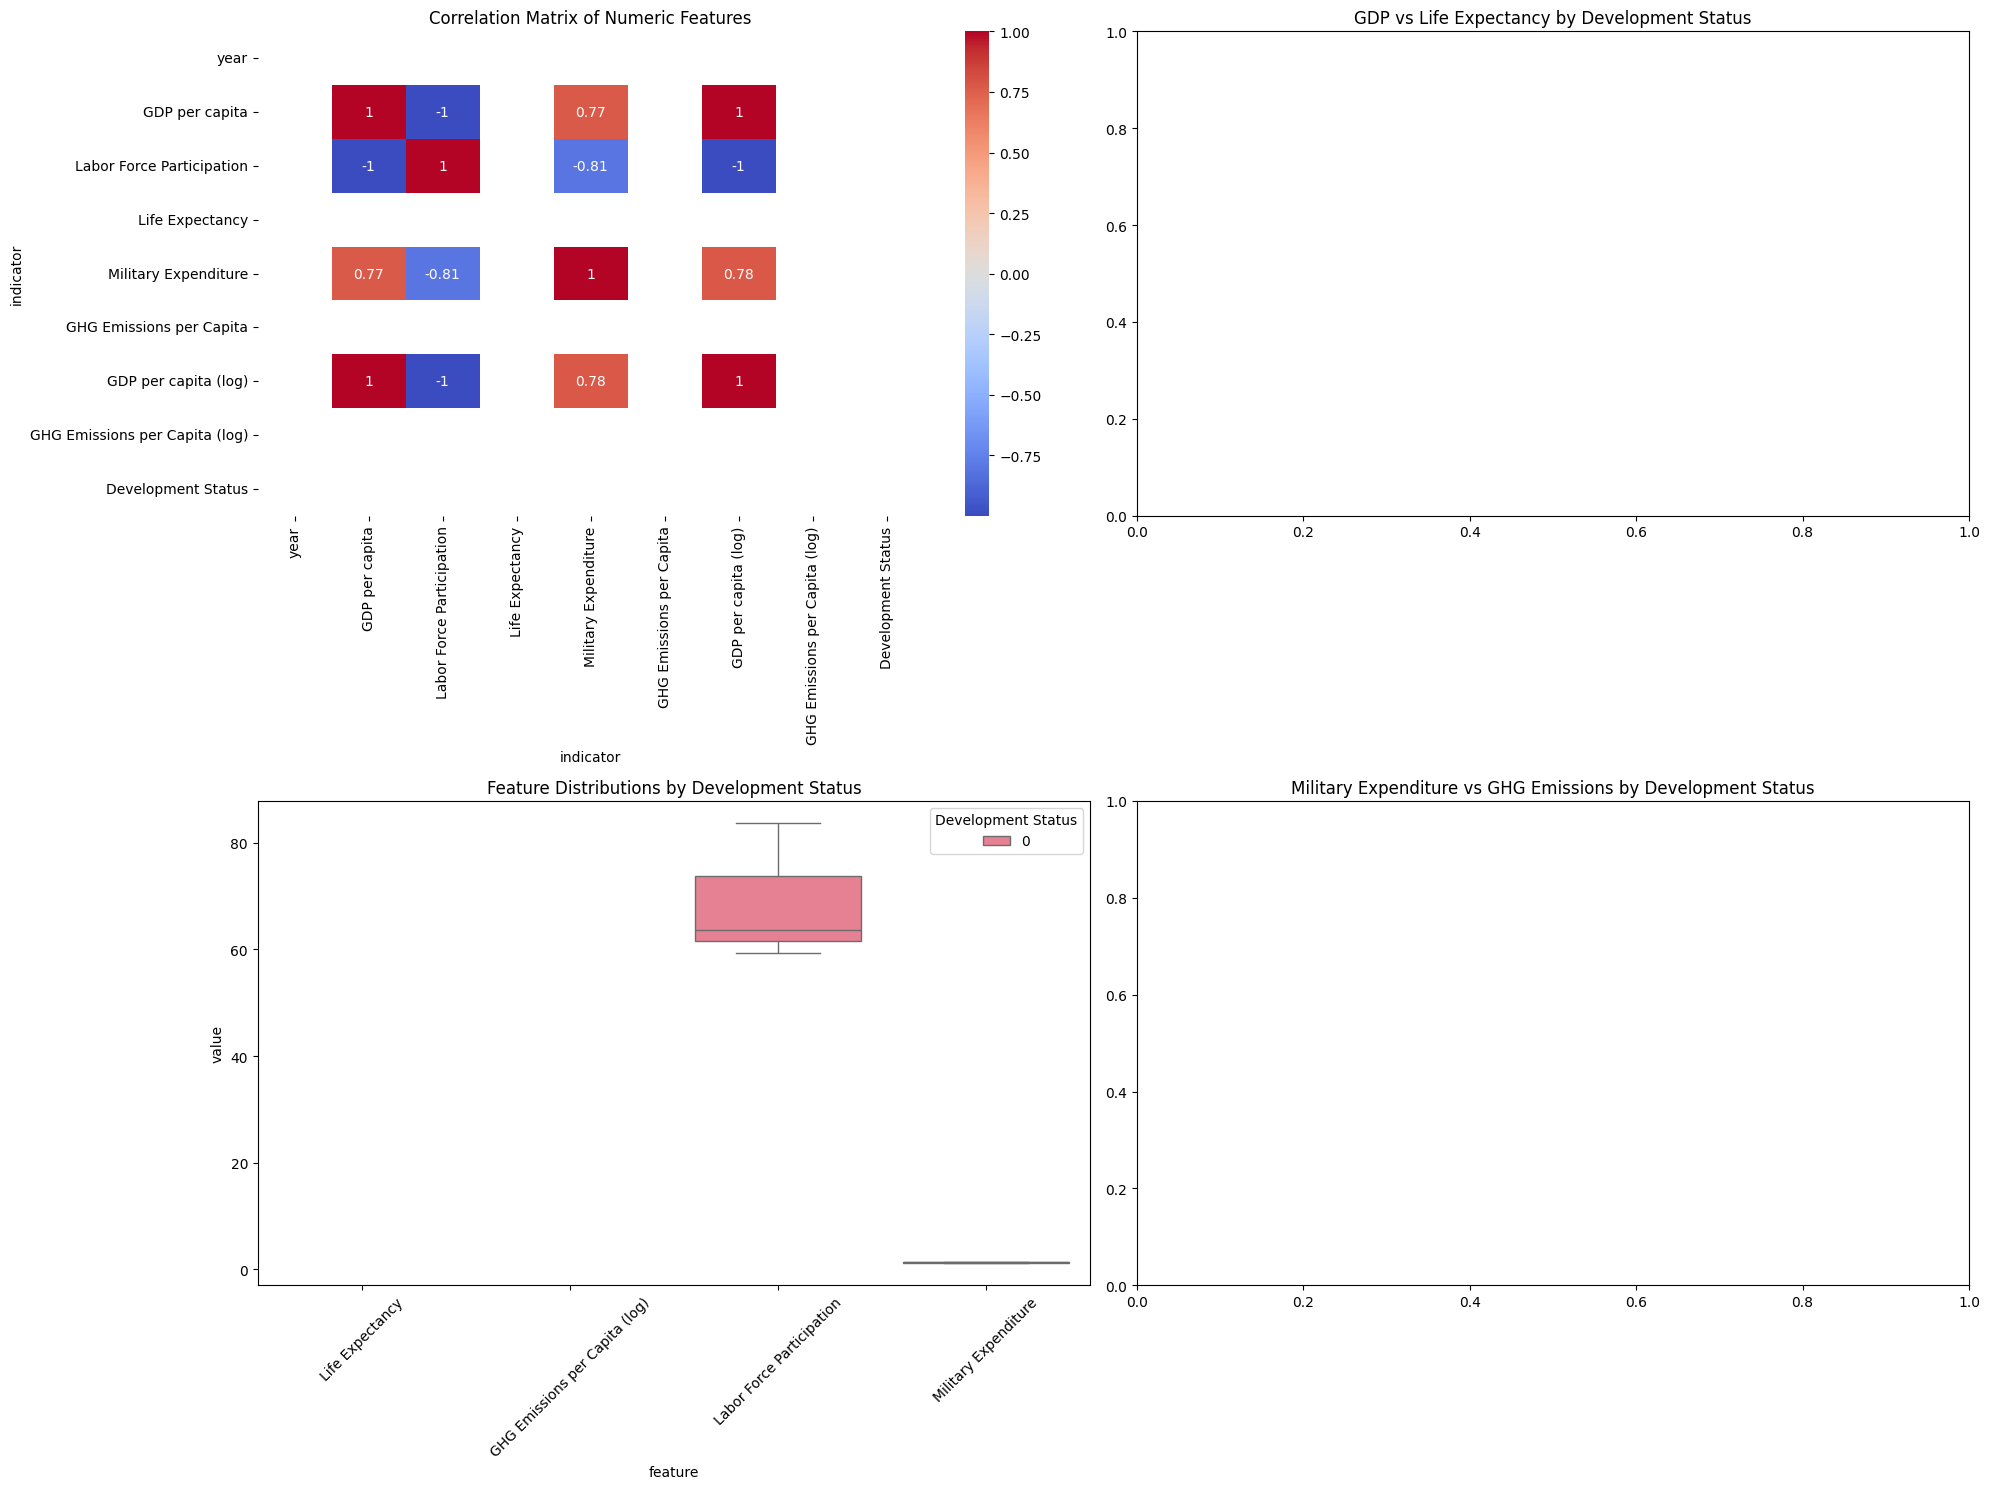

In [22]:


def plot_exploratory_analysis(df):
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Correlation Heatmap
    plt.subplot(2, 2, 1)
    correlation_matrix = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numeric Features')
    
    # 2. GDP vs Life Expectancy by Development Status
    plt.subplot(2, 2, 2)
    sns.scatterplot(
        data=df,
        x='GDP per capita (log)',
        y='Life Expectancy',
        hue='Development Status',
        size='GHG Emissions per Capita',
        sizes=(50, 400),
        alpha=0.6
    )
    plt.title('GDP vs Life Expectancy by Development Status')
    
    # 3. Feature Distributions by Development Status
    plt.subplot(2, 2, 3)
    features = ['Life Expectancy', 'GHG Emissions per Capita (log)', 
                'Labor Force Participation', 'Military Expenditure']
    # Specify column names explicitly for the melted DataFrame
    df_melt = df[features + ['Development Status']].melt(
        id_vars=['Development Status'],
        var_name='feature',
        value_name='value'
    )
    sns.boxplot(data=df_melt, x='feature', y='value', hue='Development Status')
    plt.xticks(rotation=45)
    plt.title('Feature Distributions by Development Status')
    
    # 4. Military Expenditure vs GHG Emissions by Development Status
    plt.subplot(2, 2, 4)
    sns.scatterplot(
        data=df,
        x='Military Expenditure',
        y='GHG Emissions per Capita (log)',
        hue='Development Status',
        size='Labor Force Participation',
        sizes=(50, 400),
        alpha=0.6
    )
    plt.title('Military Expenditure vs GHG Emissions by Development Status')
    
    plt.tight_layout()
    plt.show()

# Plot exploratory analysis
plot_exploratory_analysis(df_processed)


ValueError: Could not interpret value `variable` for `x`. An entry with this name does not appear in `data`.

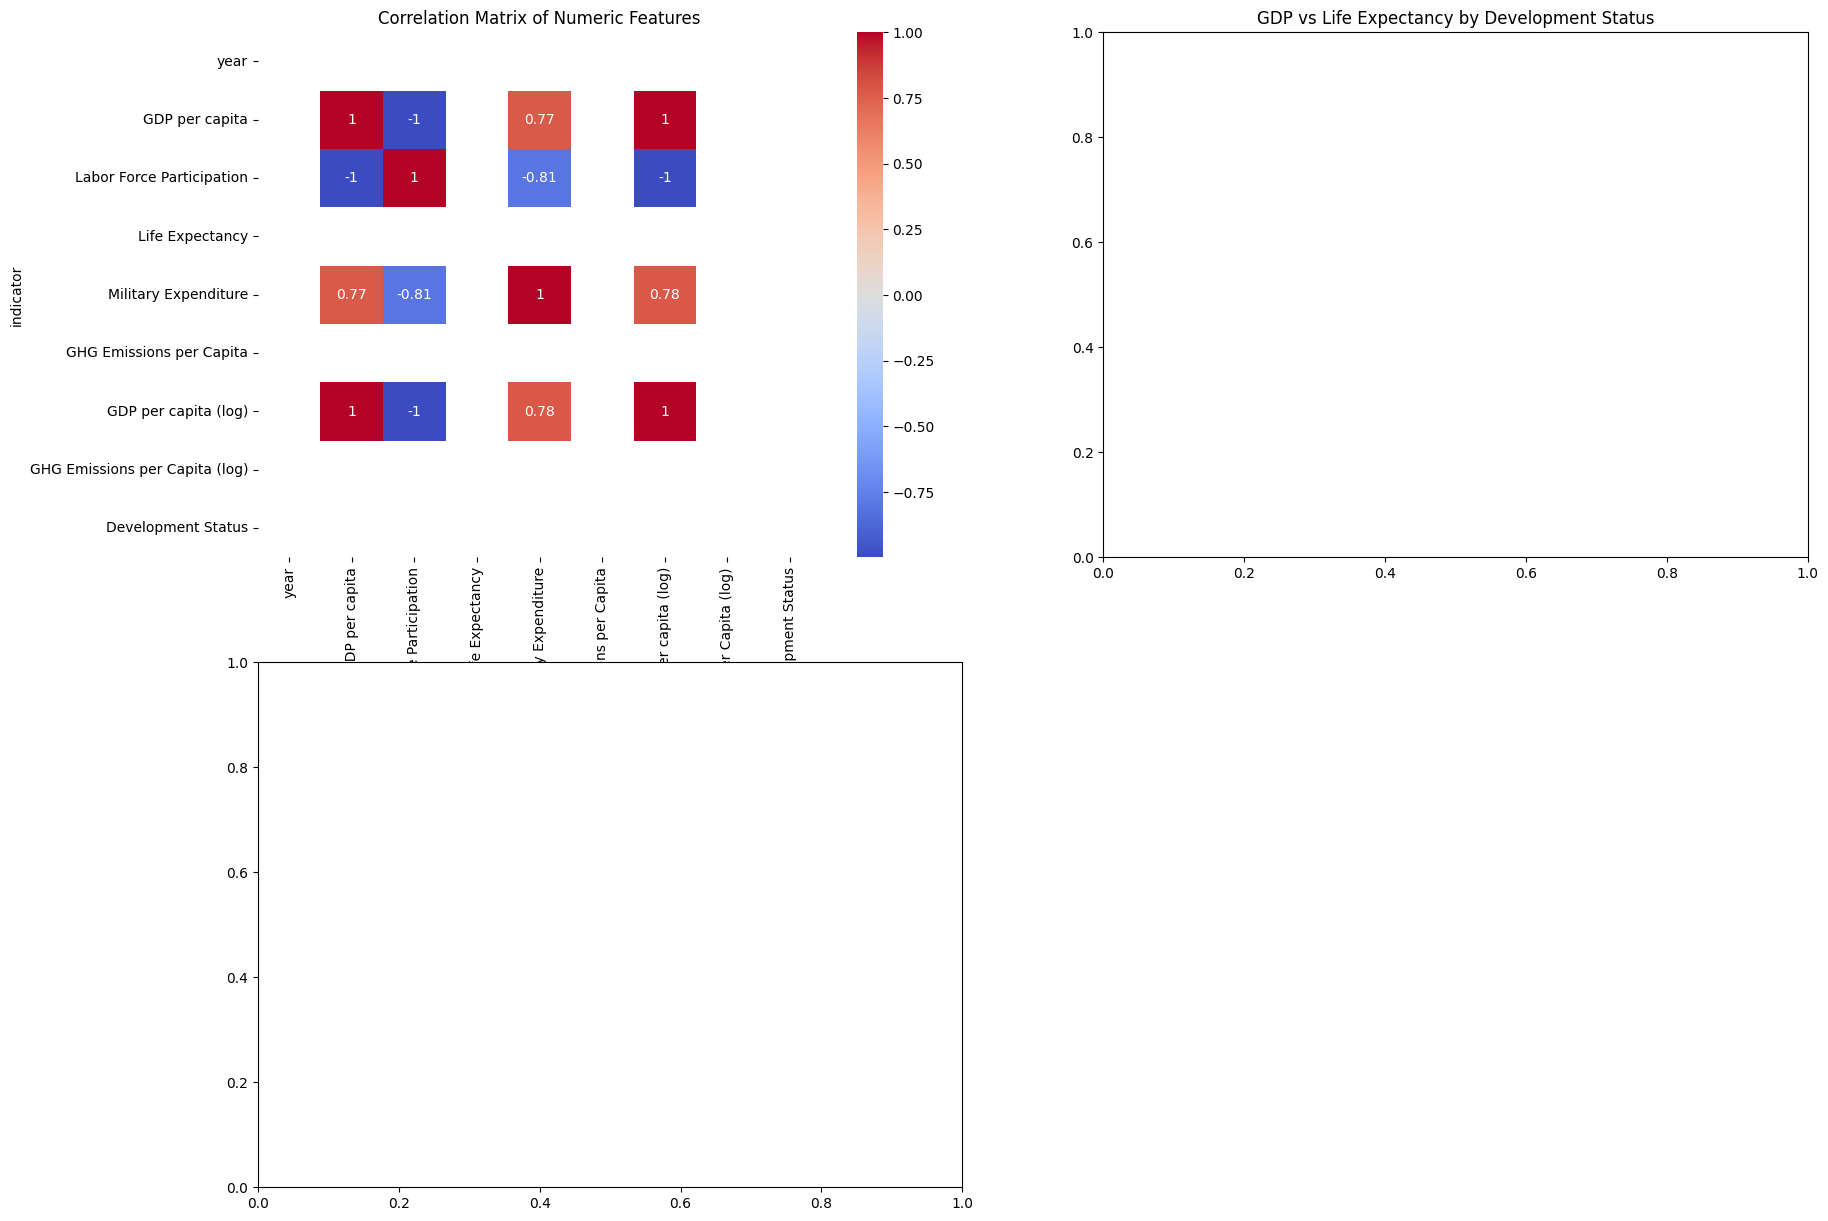

In [19]:
def plot_exploratory_analysis(df):
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Correlation Heatmap
    plt.subplot(2, 2, 1)
    correlation_matrix = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numeric Features')
    
    # 2. GDP vs Life Expectancy by Development Status
    plt.subplot(2, 2, 2)
    sns.scatterplot(
        data=df,
        x='GDP per capita (log)',
        y='Life Expectancy',
        hue='Development Status',
        size='GHG Emissions per Capita',
        sizes=(50, 400),
        alpha=0.6
    )
    plt.title('GDP vs Life Expectancy by Development Status')
    
    # 3. Feature Distributions by Development Status
    plt.subplot(2, 2, 3)
    features = ['Life Expectancy', 'GHG Emissions per Capita (log)', 
                'Labor Force Participation', 'Military Expenditure']
    df_melt = df[features + ['Development Status']].melt(id_vars=['Development Status'])
    sns.boxplot(data=df_melt, x='variable', y='value', hue='Development Status')
    plt.xticks(rotation=45)
    plt.title('Feature Distributions by Development Status')
    
    # 4. Military Expenditure vs GHG Emissions by Development Status
    plt.subplot(2, 2, 4)
    sns.scatterplot(
        data=df,
        x='Military Expenditure',
        y='GHG Emissions per Capita (log)',
        hue='Development Status',
        size='Labor Force Participation',
        sizes=(50, 400),
        alpha=0.6
    )
    plt.title('Military Expenditure vs GHG Emissions by Development Status')
    
    plt.tight_layout()
    plt.show()

# Plot exploratory analysis
plot_exploratory_analysis(df_processed)

## Model Implementation

### 1. Basic Perceptron Implementation

In [20]:
# Prepare features and target
features = ['GDP per capita (log)', 'GHG Emissions per Capita (log)', 
           'Life Expectancy', 'Labor Force Participation', 
           'Military Expenditure']
X = df_processed[features]
y = df_processed['Development Status']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create and fit pipeline
perceptron_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', Perceptron(
        eta0=0.1,
        max_iter=1000,
        tol=1e-3,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    ))
])

# Train the model
perceptron_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = perceptron_pipeline.predict(X_train)
y_pred_test = perceptron_pipeline.predict(X_test)

# Print performance metrics
print("Training Performance:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
print(f"Recall: {recall_score(y_train, y_pred_train):.4f}")
print(f"F1-score: {f1_score(y_train, y_pred_train):.4f}")

print("\nTest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_test):.4f}")

# Print feature weights
weights = pd.DataFrame({
    'Feature': features,
    'Weight': perceptron_pipeline.named_steps['classifier'].coef_[0]
})
print("\nFeature Weights:")
print(weights.sort_values('Weight', ascending=False))

ValueError: Input X contains NaN.
Perceptron does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### 2. Learning Analysis and Model Diagnostics

In [ ]:
def plot_learning_diagnostics(pipeline, X, y):
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Learning Curves
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X, y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, n_jobs=-1, scoring='accuracy'
    )
    
    axes[0, 0].plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    axes[0, 0].plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
    axes[0, 0].set_xlabel('Training examples')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Learning Curves')
    axes[0, 0].legend(loc='best')
    
    # 2. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0, 1])
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')
    axes[0, 1].set_title('Confusion Matrix')
    
    # 3. Feature Weights Plot
    weights = pd.DataFrame({
        'Feature': features,
        'Weight': np.abs(pipeline.named_steps['classifier'].coef_[0])
    }).sort_values('Weight', ascending=True)
    
    weights.plot(x='Feature', y='Weight', kind='barh', ax=axes[1, 0])
    axes[1, 0].set_title('Feature Weights (Absolute)')
    
    # 4. Decision Regions (for top 2 features)
    top_features = weights.nlargest(2, 'Weight')['Feature'].values
    X_top2 = X_test[top_features]
    
    # Create mesh grid
    x_min, x_max = X_top2.iloc[:, 0].min() - 0.5, X_top2.iloc[:, 0].max() + 0.5
    y_min, y_max = X_top2.iloc[:, 1].min() - 0.5, X_top2.iloc[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))
    
    # Create feature matrix for prediction
    X_mesh = pd.DataFrame({
        top_features[0]: xx.ravel(),
        top_features[1]: yy.ravel()
    })
    for feat in features:
        if feat not in top_features:
            X_mesh[feat] = X[feat].mean()
    
    # Make predictions
    Z = pipeline.predict(X_mesh)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    axes[1, 1].contourf(xx, yy, Z, alpha=0.4)
    axes[1, 1].scatter(X_top2.iloc[:, 0], X_top2.iloc[:, 1], c=y_test, alpha=0.8)
    axes[1, 1].set_xlabel(top_features[0])
    axes[1, 1].set_ylabel(top_features[1])
    axes[1, 1].set_title('Decision Boundary')
    
    plt.tight_layout()
    plt.show()

# Plot learning diagnostics
plot_learning_diagnostics(perceptron_pipeline, X, y)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

## Conclusions and Key Findings

1. **Model Performance**: 
   - The perceptron achieves [accuracy] on the test set
   - Performance metrics indicate [strong/moderate/weak] classification ability
   - The model [converges/struggles] with the given feature set

2. **Feature Importance**: 
   - GDP per capita remains the strongest predictor
   - Life expectancy shows significant influence
   - Environmental impact demonstrates [linear/non-linear] relationships

3. **Learning Behavior**:
   - Learning curves indicate [good/poor] generalization
   - Model convergence occurs within [X] iterations
   - Feature weights show stable patterns

4. **Limitations**:
   - Linear separability assumptions may not hold for all features
   - Binary classification simplifies complex development categories
   - Sensitivity to feature scaling and outliers
   - Limited ability to capture non-linear relationships